In [1]:
import numpy as np
import bz2
from collections import Counter
import re
import nltk
import torch
import math
from torch import nn
from torch import optim
from torch import Tensor
from torch import LongTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import random
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.stats import rankdata
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)
nn_Softargmax = nn.Softmax

In [3]:
%matplotlib inline
#%pylab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = '/content/drive/My Drive/RA - Pathak/Attn/data/'

## Load the dataset

In [8]:
normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST
transform = transforms.Compose([ transforms.ToTensor(), normalize ])

train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

valid_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

In [9]:
bs = 200
valid_size = 0.2
num_workers = 4
pin_memory = True
data_dir = "~/torch_datasets"
shuffle = False
random_seed = 42

# load the dataset
train_dataset = datasets.MNIST(root=data_dir, train=True, 
            download=True, transform=transform)

valid_dataset = datasets.MNIST(root=data_dir, train=True, 
            download=True, transform=transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=bs, sampler=train_sampler, 
                num_workers=num_workers, pin_memory=pin_memory)

val_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=bs, sampler=valid_sampler, 
                num_workers=num_workers, pin_memory=pin_memory)

test_indices = [x for x in range(1000)]

test_loader = DataLoader(
    test_dataset, batch_size=50, shuffle=False, num_workers=6
)
# test_loader = DataLoader(
#     test_dataset, batch_size=bs, shuffle=False, num_workers=4, sampler=SubsetRandomSampler(test_indices)
# )

In [10]:
len(test_loader)

200

### Old loader

In [ ]:
mnist = np.load("/content/drive/My Drive/RA - Pathak/AFS/data/mnist_rc.npz")

In [ ]:
mnist_train_X, mnist_train_Y, mnist_val_X, mnist_val_Y, mnist_test_X, mnist_test_Y = mnist['train_X'][0], mnist['train_Y'][0], mnist['val_X'], mnist['val_Y'], mnist['test_X'][0], mnist['test_Y'][0]

## convert labels from one-hot encoding to single label
mnist_train_Y = [np.argmax(i) for i in mnist_train_Y]
mnist_val_Y = [np.argmax(i) for i in mnist_val_Y]
mnist_test_Y = [np.argmax(i) for i in mnist_test_Y]

In [ ]:
len(mnist_test_Y)

10000

In [ ]:
batch_size = 100
n_iters = 3000
train_loader = DataLoader(TensorDataset(Tensor(mnist_train_X), LongTensor(mnist_train_Y)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(Tensor(mnist_val_X), LongTensor(mnist_val_Y)), batch_size=batch_size)
test_loader = DataLoader(Tensor(mnist_test_X), batch_size=batch_size)

### Chek GPU

In [11]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [12]:
device

device(type='cuda')

In [13]:
c = torch.rand(1, 28 , 28)
c = c.view(-1,28,28)
c.shape

torch.Size([1, 28, 28])

In [14]:
device

device(type='cuda')

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, p, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = nn_Softargmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        # print('MHA attn weight shape:', A.shape)
        # print('MHA output shape:', H.shape)
        
        return H, A

In [16]:
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, p=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads, p)
        self.cnn = CNN(d_model, conv_hidden_dim, p)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, attn_weights = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weights

In [18]:
def create_sinusoidal_embeddings(nb_p, dim, E):
    theta = np.array([
        [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_p)
    ])
    E[:, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    E[:, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    E.detach_()
    E.requires_grad = False
    E = E.to(device)

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, p):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = nn.Embedding(max_position_embeddings, d_model)
        create_sinusoidal_embeddings(
            nb_p=max_position_embeddings,
            dim=d_model,
            E=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                      # (bs, max_seq_length)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for each position id 
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)
        
        # Add them both 
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [19]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        #self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding, p)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, p))
        
    def forward(self, x):
        #x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x, attn_weights = self.enc_layers[i](x)

        return x, attn_weights  # (batch_size, input_seq_len, d_model)

In [146]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        # self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
        #                  maximum_position_encoding=10000)
        self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(p=0.3)
        self.tanh = nn.Tanh()
        self.softmax_fc = nn.Softmax(dim=1)
        self.dense2 = nn.Linear(784, num_answers)

    def forward(self, x):
        x, attn_weights = self.encoder(x)
        # print('out1',x.shape)
        # [100,200,32]
        # print('attn1',attn_weights.shape)
        
        #x, _ = torch.max(x, dim=1)
        out = self.dense(x)
        out = self.dropout(out)
        out = self.tanh(out)
        # print('out dense1',out.shape)
        # [100,200,1]
        # print('attn dense1',attn_weights.shape)
        out = out.squeeze()
        # [100,200,1]
        out = self.dense2(out)
        out = self.softmax_fc(out)
        # [100,2]
        # print('out final ',out.shape)
        # print('attn final ',attn_weights.shape)
        return out, attn_weights

In [147]:
def train(train_loader, val_loader, input_dim, sequence_length, output_size, batch_size, num_epochs):

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
    # optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    #optimizer = optim.RMSprop(model.parameters(), lr=0.1)
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    all_train_loss = []
    all_val_loss = []

    
    for epoch in range(num_epochs):
    
        model.train()

        t_loss = []
        v_loss = []
    
    
        for i, (images, labels) in enumerate(train_loader):
    
            optimizer.zero_grad()
    
            images = images.reshape(-1, sequence_length, input_dim).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs,  _ = model(images)
            loss = criterion(outputs, labels)
            t_loss.append(loss.item())
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
        
        all_train_loss.append(np.mean(t_loss))
            
        # Test the model
        model.eval()

        for images, labels in val_loader:
            images = images.reshape(-1, sequence_length, input_dim).to(device)
            labels = labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            v_loss.append(loss.item())
    
        all_val_loss.append(np.mean(v_loss))
    
        logging.info('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}'  .format(epoch+1,num_epochs, np.mean(t_loss), np.mean(v_loss)))

    return [all_train_loss, all_val_loss, model]

## Training

In [148]:
num_epochs = 20
sequence_length = 784
batch_size = 200
output_size = 10
input_dim = 1
#embedding_dim = 100
hidden_dim = 64
n_layers = 1
drop_prob=0.3

model = TransformerClassifier(num_layers=1, d_model=input_dim, num_heads=1,conv_hidden_dim=hidden_dim, input_vocab_size=1, num_answers=output_size)
model.to(device)
# model = Model(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
# model = model.to(device)
model

TransformerClassifier(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=1, out_features=1, bias=False)
          (W_k): Linear(in_features=1, out_features=1, bias=False)
          (W_v): Linear(in_features=1, out_features=1, bias=False)
          (W_h): Linear(in_features=1, out_features=1, bias=True)
        )
        (cnn): CNN(
          (k1convL1): Linear(in_features=1, out_features=64, bias=True)
          (k1convL2): Linear(in_features=64, out_features=1, bias=True)
          (activation): ReLU()
        )
        (layernorm1): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
        (layernorm2): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
      )
    )
  )
  (dense): Linear(in_features=1, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
  (softmax_fc): Softmax(dim=1)
  (dense2): Linear(in_features=784, out_features=10, bias=True)
)

In [149]:
lstm = train(train_loader, val_loader, input_dim, sequence_length, output_size, batch_size, num_epochs)

23-Feb-21 21:13:42 - Epoch [1/20], train_loss: 2.3023, val_loss: 2.3020
23-Feb-21 21:13:49 - Epoch [2/20], train_loss: 2.3020, val_loss: 2.3016
23-Feb-21 21:13:55 - Epoch [3/20], train_loss: 2.3017, val_loss: 2.3014
23-Feb-21 21:14:02 - Epoch [4/20], train_loss: 2.3016, val_loss: 2.3012
23-Feb-21 21:14:09 - Epoch [5/20], train_loss: 2.3015, val_loss: 2.3012
23-Feb-21 21:14:15 - Epoch [6/20], train_loss: 2.3015, val_loss: 2.3011
23-Feb-21 21:14:22 - Epoch [7/20], train_loss: 2.3014, val_loss: 2.3011
23-Feb-21 21:14:29 - Epoch [8/20], train_loss: 2.3015, val_loss: 2.3010
23-Feb-21 21:14:36 - Epoch [9/20], train_loss: 2.3015, val_loss: 2.3010
23-Feb-21 21:14:42 - Epoch [10/20], train_loss: 2.3015, val_loss: 2.3010
23-Feb-21 21:14:49 - Epoch [11/20], train_loss: 2.3015, val_loss: 2.3010
23-Feb-21 21:14:56 - Epoch [12/20], train_loss: 2.3014, val_loss: 2.3010
23-Feb-21 21:15:02 - Epoch [13/20], train_loss: 2.3014, val_loss: 2.3010
23-Feb-21 21:15:09 - Epoch [14/20], train_loss: 2.3014, val_

In [150]:
all_train_loss = lstm[0]
all_val_loss = lstm[1]
model = lstm[2]

In [151]:
model_dir = '/content/drive/My Drive/RA - Pathak/Attn/data/'
# torch.save(model, model_dir + "mnist_attn_2.pickle")
#model = torch.load(model_dir + "mnist_attn.pickle", map_location=torch.device('cpu'))

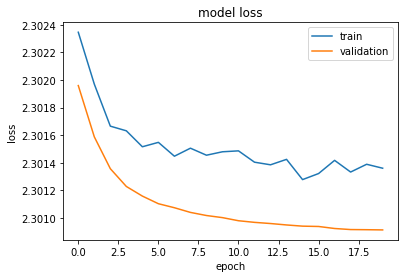

In [152]:
figsize(6,4)
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Testing

In [153]:
def predict(test_loader, input_dim, sequence_length, hidden_dim, batch_size):
    test_losses = []
    a_weights = []
    true_labels = []
    
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_dim).to(device)
            images, labels = images.to(device), labels.to(device)
            output, a_out = model(images)
    
            for each_a_out in a_out:
                x = each_a_out.squeeze().cpu()
                x = torch.mean(x,0)
                a_weights.append(x.numpy())

            test_loss = criterion(output, labels)
            test_losses.append(test_loss.item())
    
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    return a_weights, true_labels


In [154]:
weights, t_labels = predict(test_loader, input_dim, sequence_length, hidden_dim, batch_size=100)

Test loss: 2.301


In [155]:
len(weights)

10000

In [156]:
w = weights

## Plot Heatmap

In [157]:
print('weights',len(w[0]))
numbers = 10
mnist_weights = [w[i] for i in range(numbers)]
ranks = []
for i in range(numbers):
    mnist_ranks = np.array([783 - x for x in rankdata(mnist_weights[i], method='ordinal')])
    ranks.append(mnist_ranks)

len(ranks)

weights 784


10

In [158]:
%matplotlib inline
# %pylab

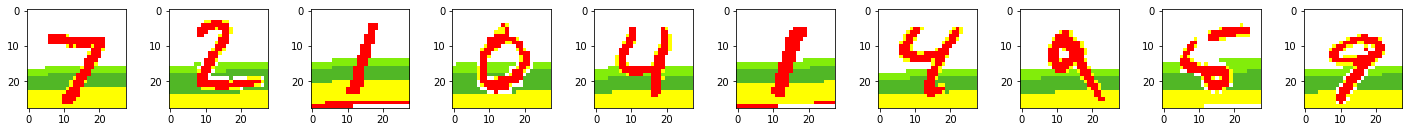

In [159]:
figsize(25,4)
viridis = cm.get_cmap('viridis', 784)
colors = viridis(np.linspace(0, 1, 784))
red = np.array([1, 0, 0, 1])
yellow = np.array([1, 1, 0, 1])
green = np.array([0.32, 0.72, 0.15, 1])
lime = np.array([0.51, 0.93, 0.04, 1])
white = np.array([1, 1, 1, 1])
# colors[:65, :] = red
# colors[65:150, :] = yellow
# colors[150:200, :] = green
# colors[200:350, :] = lime
# colors[350:, :] = white
colors[:100, :] = red
colors[100:250, :] = yellow
colors[250:350, :] = green
colors[350:450, :] = lime
colors[400:, :] = white
colors = ListedColormap(colors)
for i in range(numbers):
    #title('Attention')
    plt.subplot(2, numbers, i+1)
    plt.imshow(ranks[i].reshape((28,28)), cmap=colors)

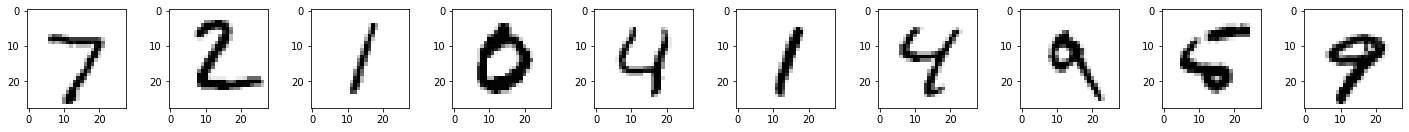

In [160]:
for i in range(numbers):
    plt.subplot(2, numbers, i+1)
    plt.imshow(test_dataset[i][0].squeeze().reshape((28,28)), cmap='binary')